## Lending Club analysis 

The objective is to build a model that predicts return rate (or something like that) for loans.

Start simple:  classification (payback/don't payback) 

In [1]:
import pandas as pd

### Read in the data

These are the Q1 2017 loans.  [data should be here](https://www.lendingclub.com/statistics/additional-statistics?) but something is wrong.  In any case, I managed to download the 2017 data.

In [2]:
LC_raw = pd.read_csv("./data/Loan_stats_2017_top1000.csv",header=1,skiprows=0)

In [3]:
LC_raw.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,104160129,NaN,6000,6000,6000,36 months,7.24%,185.93,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,104170260,NaN,17000,17000,17000,36 months,7.49%,528.73,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,103952006,NaN,14000,14000,14000,60 months,12.74%,316.69,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,103347407,NaN,9900,9900,9900,36 months,5.32%,298.14,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,103470623,NaN,15400,15400,15400,60 months,11.39%,337.84,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
5,104047067,NaN,10000,10000,10000,36 months,7.99%,313.32,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
6,104048642,NaN,10000,10000,10000,36 months,7.49%,311.02,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
7,104280288,NaN,3025,3025,3025,36 months,6.99%,93.39,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
8,104070168,NaN,9000,9000,9000,36 months,11.39%,296.32,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
9,104210150,NaN,12000,12000,12000,36 months,6.99%,370.48,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
LC_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 150 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          int64  
 1   member_id                                   float64
 2   loan_amnt                                   int64  
 3   funded_amnt                                 int64  
 4   funded_amnt_inv                             int64  
 5   term                                        object 
 6   int_rate                                    object 
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                        

## Target variable

Training data are from Q1, 2017; 3 years ago.  Most of the 3 year loans should be [Fully Paid or Charged off](https://help.lendingclub.com/hc/en-us/articles/215488038). Five-year loans can still be current. 

The length of the terms makes building training data a challenge, if I want to give five-year loans sufficient time to mature I have to use training data that is 5+ years old. Loans that old are unlikely to reflect current trends (they are not _representative_ to the loans being requested now). 

On the other hand choosing a short window will not show the entire picture; how many loans default after the first year or two?  

I chose 3 years as a compromise.  

Obviously, loans requested 3 years ago probably don't reflect current loans, we are in the middle of a global pandemic. Unbiased inference is always a problem in statistical modeling and is beyond the scope of this quick analysis.

The return on investment will be the 3-year total amount paid to date (total_pymnt) minus the initial investment.  This will be prorated to a \\$100 investment:

ROI = (total_pymnt/loan_amnt - 1) * 100

Example #1, loan ID 104160129 is a 3-year "Fully Paid" loan; the initial loan was \\$6000 (loan_amnt) and they paid \\$6553.12 (total_pymnt), so a \\$100 investment into this loan would net:

> ROI = (6553.12/6000 - 1) * 100 = 9.22

Example #2, loan ID 103952006 is a 5-year "Charged off" loan; the initial loan was \\$14000 (loan_amnt) and they paid \\$6,388.30 (total_pymnt) prior to defaulting, so a \\$100 investment into this loan would net:

> ROI = (6388.30/14000 - 1) * 100 = -54.13


In [42]:
LC_raw['roi']=(LC_raw.total_pymnt/LC_raw.loan_amnt - 1) * 100

In [43]:
LC_raw.roi

0       9.218622
1       1.663546
2     -54.369286
3       5.775280
4      17.876046
         ...    
993    23.559498
994    10.019911
995    11.471286
996    21.650448
997    31.750308
Name: roi, Length: 998, dtype: float64

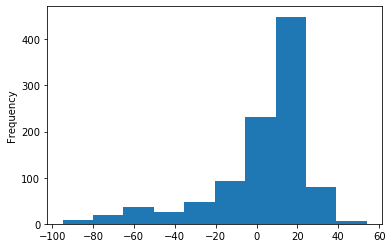

In [44]:
LC_raw.roi.plot.hist()

In [47]:
# total investment $100 per loan
LC_raw.roi.count()*100

99800

In [48]:
LC_raw.roi.sum()

2766.4418549358743

In [49]:
# not exactly a 7% return as advertised
LC_raw.roi.sum()/(LC_raw.roi.count()*100)

0.027719858265890525

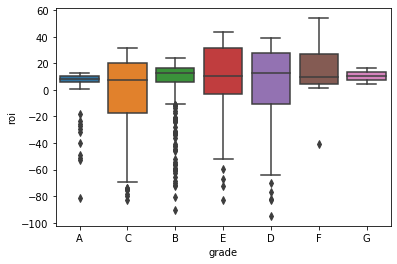

In [52]:
# data is biased because it only includes funded loans.  Clearly some loans will not get funded
import seaborn as sb
sb.boxplot(x=LC_raw.grade,y=LC_raw.roi)

### Feature EDA

Full data list is [here](https://docs.google.com/spreadsheets/d/16fqmVyjloON5Efo51wHtyNodsNwEPvSzkYsUP0QoZm4/edit#gid=1283882092) and sample data [here](https://docs.google.com/spreadsheets/d/13wa-cJcNWSenJAEBTVo9u0DpoiBe7ruVIAiPA2sDnyE/edit#gid=1876307080). From the initial list of data I took the following steps:
1. Identified features from the long list of variables.  Obviously focused on features that are avaliable at the time the loan is being funded. 
2. Classified as continuous (including ints) or discrete.
3. Graphed the data, looked for nulls, and identified any transformations. 

For the most part these data are amazingly well behaved. Only need a few transformations and imputations. 

"Coded" list of features are in the [Data Dictionary](https://docs.google.com/spreadsheets/d/16fqmVyjloON5Efo51wHtyNodsNwEPvSzkYsUP0QoZm4/edit#gid=1283882092).

More details & visualizations of the EDA are in Appendix A.

### Training data

In [53]:
LC_train_y = LC_raw[['roi']]
LC_train_y

,roi
0,9.218622
1,1.663546
2,-54.369286
3,5.775280
4,17.876046
...,...
993,23.559498
994,10.019911
995,11.471286
996,21.650448


#### One-hot encoding 

For the random forest I am using one-hot encoding for all categorical variables.  This will create many hundreds of features to contrast with the embeddings approach.

1.  I include zip-code which is the source of most dummy variables -- the resulting small sample sizes and high cardinality is going to be very difficult for small trees to use effectively.
2.  Term is a categorical variable
3.  sub-grade is a subset of grade and is [colinear to the interest rate](https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees)

In [54]:
LC_raw_cats = LC_raw[[
'term',
'emp_length',
'emp_title',
'grade',
'home_ownership',
'purpose',
'sub_grade',
'zip_code',
'addr_state',
'title',
'verification_status']]

In [55]:
LC_raw_cats.head()

,term,emp_length,emp_title,grade,home_ownership,purpose,sub_grade,zip_code,addr_state,title,verification_status
0,36 months,3 years,Program Manager,A,RENT,credit_card,A3,981xx,WA,Credit card refinancing,Source Verified
1,36 months,10+ years,Air Traffic Controller,A,MORTGAGE,debt_consolidation,A4,840xx,UT,Debt consolidation,Not Verified
2,60 months,9 years,Relocation Specialist,C,RENT,debt_consolidation,C1,980xx,WA,Debt consolidation,Not Verified
3,36 months,10+ years,Radtech,A,MORTGAGE,debt_consolidation,A1,307xx,GA,Debt consolidation,Not Verified
4,60 months,10+ years,Social worker,B,MORTGAGE,debt_consolidation,B3,068xx,CT,Debt consolidation,Not Verified


In [56]:
LC_train_catx = pd.get_dummies(LC_raw_cats)

In [57]:
LC_train_catx.head()

,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,...,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Continuous features

Only a few require transformations:
1. Several convert to 0/1 since they have very few non-zero entries.
2. Interest rate needs to be converted to a float value.
3. Some of these probably could use a log or sqrt transformation but I am going to ignore the skewness for now. I should update later. _**tag:TODO=deal with skewness**_

In [58]:
LC_train_numx = LC_raw[['int_rate',
'annual_inc',
'delinq_2yrs',
'dti',
'fico_range_high',
'fico_range_low',
'inq_last_6mths',
'loan_amnt',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'total_bal_ex_mort',
'acc_now_delinq',
'installment',
'collections_12_mths_ex_med',
'inq_last_12m',
'num_bc_tl',
'num_op_rev_tl',
'num_tl_op_past_12m',
'percent_bc_gt_75',
'revol_bal',
'tax_liens',
'tot_hi_cred_lim',
'total_bc_limit',
'pub_rec_bankruptcies']]

#### convert to 0/1

In [59]:
# these throw an warning but seem to work, there is probably a better way to do this
LC_train_numx.loc[:,'acc_now_delinq'] = ((LC_raw['acc_now_delinq'] > 0).astype(int))
LC_train_numx['collections_12_mths_ex_med'] = (LC_train_numx['collections_12_mths_ex_med']>0).astype(int)
LC_train_numx.loc[:,'tax_liens'] = ((LC_train_numx['tax_liens'] > 0).astype(int))
LC_train_numx.loc[:,'pub_rec_bankruptcies'] = ((LC_train_numx['pub_rec_bankruptcies'] > 0).astype(int))



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
LC_train_numx['acc_now_delinq'].value_counts()

0    993
1      5
Name: acc_now_delinq, dtype: int64

#### change int_rate from string to float

In [61]:
## Interest rate
## this also throws a warning but seems to work
LC_train_numx['int_rate'] = LC_train_numx['int_rate'].str.replace('%','',regex=False).astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


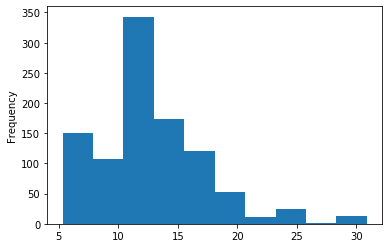

In [62]:
LC_train_numx['int_rate'].plot.hist()

#### Missing values
1. imputation done by context, not statistical imputation (_e.g._ median or average)
1. for recency variables I use 999 because larger numbers should be "better" (never do this with a linear model)



In [63]:
for col in LC_train_numx.columns:
    print(col," ",LC_train_numx[col].isna().sum())

int_rate   0
annual_inc   0
delinq_2yrs   0
dti   2
fico_range_high   0
fico_range_low   0
inq_last_6mths   0
loan_amnt   0
mths_since_last_delinq   507
mths_since_last_record   807
open_acc   0
pub_rec   0
total_acc   0
total_bal_ex_mort   0
acc_now_delinq   0
installment   0
collections_12_mths_ex_med   0
inq_last_12m   0
num_bc_tl   0
num_op_rev_tl   0
num_tl_op_past_12m   0
percent_bc_gt_75   9
revol_bal   0
tax_liens   0
tot_hi_cred_lim   0
total_bc_limit   0
pub_rec_bankruptcies   0


In [64]:
values = {'dti': 99, 'percent_bc_gt_75': 0, 'mths_since_last_delinq': 999, 'mths_since_last_record': 999}
LC_train_numx = LC_train_numx.fillna(value=values)

### Bring all features together into feature dataset

In [65]:
LC_train_x = pd.concat([LC_train_numx,LC_train_catx], axis=1, sort=False)


In [66]:
#1310 features!
LC_train_x

,int_rate,annual_inc,delinq_2yrs,dti,fico_range_high,fico_range_low,inq_last_6mths,loan_amnt,mths_since_last_delinq,mths_since_last_record,...,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,7.24,125000.0,0,9.25,694,690,1,6000,54.0,999.0,...,0,0,0,0,0,0,0,0,1,0
1,7.49,120000.0,0,8.41,739,735,0,17000,72.0,89.0,...,0,0,0,0,0,0,0,1,0,0
2,12.74,49960.0,0,9.30,719,715,0,14000,999.0,90.0,...,0,0,0,0,0,0,0,1,0,0
3,5.32,53000.0,1,19.47,734,730,0,9900,16.0,999.0,...,0,0,0,0,0,0,0,1,0,0
4,11.39,95000.0,0,11.52,734,730,0,15400,34.0,999.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,15.99,43000.0,1,35.31,669,665,0,6025,21.0,999.0,...,0,0,0,0,0,1,0,0,0,1
994,8.24,104700.0,0,11.05,669,665,0,11200,31.0,999.0,...,0,0,0,0,0,0,0,0,1,0
995,7.24,86000.0,0,14.99,699,695,1,7000,999.0,87.0,...,0,0,0,0,0,0,0,0,1,0
996,12.74,45000.0,0,18.75,724,720,0,14000,999.0,999.0,...,0,0,0,0,0,0,0,1,0,0


## Random forest baseline model


#### Convert data to numpy -- RF from skicit learn likes numpy

In [67]:
import numpy as np
LC_train_x = np.array(LC_train_x)
type(LC_train_x)

numpy.ndarray

In [68]:
LC_train_y = np.array(LC_train_y)
type(LC_train_y)

numpy.ndarray

### Training and testing datasets

Split the data into train and test sets. Quick check on sample sizes.

Obviously code that I downloaded from the internets since I suddenly start using different definitions (target vs. labels).

In [69]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(LC_train_x, LC_train_y, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape,". Type:",type(train_features))
print('Training Labels Shape:', train_labels.shape,". Type:",type(train_labels))
print('Testing Features Shape:', test_features.shape,". Type:",type(test_features))
print('Testing Labels Shape:', test_labels.shape,". Type:",type(test_labels))

Training Features Shape: (748, 1310) . Type: <class 'numpy.ndarray'>
Training Labels Shape: (748, 1) . Type: <class 'numpy.ndarray'>
Testing Features Shape: (250, 1310) . Type: <class 'numpy.ndarray'>
Testing Labels Shape: (250, 1) . Type: <class 'numpy.ndarray'>


#### Train random forest

ravel() is to convert train_labels from the array shape to (n, )

In [70]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 30)
rf.fit(train_features, train_labels.ravel());

#### RF Predictions

In [71]:
predictions = rf.predict(test_features)
type(predictions)


numpy.ndarray

In [72]:
predictions

array([-14.32809678,  -4.31556242,  -9.64113401,  13.1273886 ,
        14.59788267,  -2.68400898,   7.17803569,  -6.4587861 ,
         9.32691271,  17.42009562,  19.33671165,  14.15584757,
         8.97784315,  13.42734425,  -0.53945421,   3.74223301,
        -3.8514992 ,   6.92196446,   6.14888669,  -5.25132295,
         7.02871713,  17.72615301,   6.77830086,   8.75902737,
        10.37010977,  -5.34222096, -15.48862038,  -6.88747791,
        12.680067  ,  15.94126401,  16.03222077,  16.63645691,
        -1.46391876,  10.07673213,   8.18517118,  19.36175443,
        21.09386854,  -8.82918942,  13.98593109,   9.88066044,
        10.62352413,  12.05774754, -12.3031178 , -14.64879801,
         3.23696057,   5.66607623,  19.29058096,  10.51855574,
        10.71028569,  -8.92129713,   0.41547674,  16.12817332,
        22.51190173,   7.11454713,  15.50867927,  17.11232265,
        14.33453718,  10.13624491,  15.54585533,   6.10763679,
         9.15329932,  -7.99082704,   6.86535493,  12.79

## RF Validation 

1. Confusion matrix
2. Loss function: what is the cost of a false-negative and -positive.
3. Most sensible accuracy measure
3. Interpretation - features vs. actual and predictions

In [73]:
predictions.sum()

1532.7933630919322

In [74]:
test_labels.sum()

1056.9106293872844

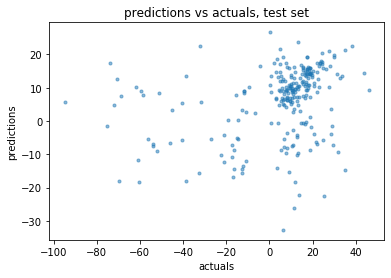

In [77]:
import matplotlib.pyplot as plt

area = np.pi*3

plt.scatter(x=test_labels, y=predictions, s=area, alpha=0.5)
plt.title('predictions vs actuals, test set')
plt.xlabel('actuals')
plt.ylabel('predictions')
plt.show()

**_tag:HERE_**

In [31]:
from sklearn.metrics import confusion_matrix

predicted_pay = (predictions > 0.5).astype(int)
confusion_matrix(test_labels, predicted_pay)

array([[46, 62],
       [50, 92]])

In [150]:
type(test_labels)

numpy.ndarray

In [172]:
feature_list = list(LC_train_x.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dti                  Importance: 0.06
Variable: installment          Importance: 0.05
Variable: tot_hi_cred_lim      Importance: 0.05
Variable: annual_inc           Importance: 0.04
Variable: total_acc            Importance: 0.04
Variable: total_bal_ex_mort    Importance: 0.04
Variable: revol_bal            Importance: 0.04
Variable: total_bc_limit       Importance: 0.04
Variable: int_rate             Importance: 0.03
Variable: loan_amnt            Importance: 0.03
Variable: num_bc_tl            Importance: 0.03
Variable: fico_range_high      Importance: 0.02
Variable: fico_range_low       Importance: 0.02
Variable: mths_since_last_delinq Importance: 0.02
Variable: open_acc             Importance: 0.02
Variable: inq_last_12m         Importance: 0.02
Variable: num_op_rev_tl        Importance: 0.02
Variable: num_tl_op_past_12m   Importance: 0.02
Variable: percent_bc_gt_75     Importance: 0.02
Variable: inq_last_6mths       Importance: 0.01
Variable: mths_since_last_record Impor

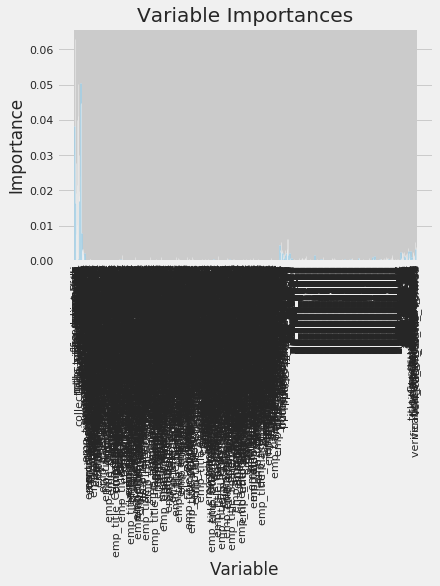

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.boxplot(x=LC_train_x['int_rate'])

ax = sns.boxplot(x="grade", y="int_rate", data=LC_train_x)

### 62 false positives

In [152]:
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '%.')

Mean Absolute Error: 0.49 %.


### that is not good

### Appendix A - feature EDA

In [67]:
# LC_raw['int_rate'].head()

LC_raw['int_rate'] = LC_raw['int_rate'].str.replace('%','',regex=False).astype(float)
LC_raw['int_rate'].value_counts()

11.49    90
12.74    76
8.24     71
15.99    70
13.49    62
11.44    62
10.49    61
14.99    58
11.39    54
13.99    54
5.32     53
7.49     43
18.99    38
7.99     36
6.99     34
16.99    32
7.24     20
17.99    19
19.99    14
22.74    12
23.99    11
25.49     9
28.69     5
24.74     4
29.99     4
26.24     2
29.49     1
30.74     1
30.89     1
30.84     1
Name: int_rate, dtype: int64

In [69]:
LC_raw['int_rate'].isna().sum()

0

In [70]:
 # LC_raw['int_rate'].head()
LC_raw['term'].value_counts()

 36 months    756
 60 months    242
Name: term, dtype: int64

In [71]:
LC_raw['term'].isna().sum()

0

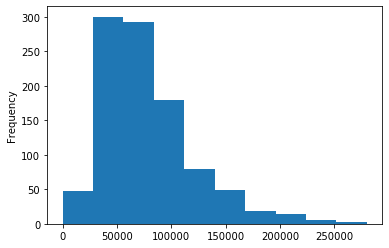

In [75]:
LC_raw['annual_inc'][LC_raw.annual_inc < 300000].plot.hist()

In [73]:
LC_raw['annual_inc'].isna().sum()

0

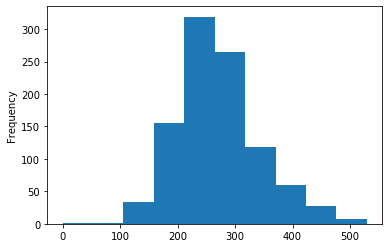

In [79]:
(LC_raw['annual_inc'][LC_raw.annual_inc < 300000]**(1/2)).plot.hist()

In [80]:
LC_raw['delinq_2yrs'].value_counts()


0    780
1    148
2     39
3     14
4      7
6      6
5      3
7      1
Name: delinq_2yrs, dtype: int64

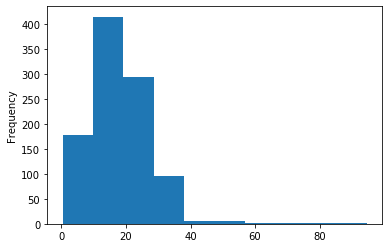

In [83]:
LC_raw['dti'].plot.hist()


In [69]:
LC_raw[LC_raw.dti.isna() == True][['dti','loan_amnt','annual_inc']]

,dti,loan_amnt,annual_inc
482,NaN,12000,0.0
923,NaN,10000,0.0


In [84]:
### TODO change this to recency

LC_raw['earliest_cr_line'].value_counts()

Jun-2003    10
Apr-2004     9
Feb-2002     9
Dec-2001     8
Feb-2007     8
            ..
Jun-2009     1
Mar-1979     1
Jun-1987     1
Aug-1985     1
May-1985     1
Name: earliest_cr_line, Length: 339, dtype: int64

In [86]:
LC_raw['emp_length'].value_counts()

10+ years    371
3 years       90
2 years       87
< 1 year      64
4 years       62
1 year        59
5 years       54
6 years       41
9 years       37
8 years       32
7 years       29
Name: emp_length, dtype: int64

In [87]:
## embedding
LC_raw['emp_title'].value_counts()

Manager                                  16
Teacher                                  16
Owner                                    10
Driver                                   10
Office Manager                            8
                                         ..
Benefit consultant                        1
Medical Laboratory Technician             1
Operations Services Senior Specialist     1
GENERAL PARTNER                           1
Consultant                                1
Name: emp_title, Length: 746, dtype: int64

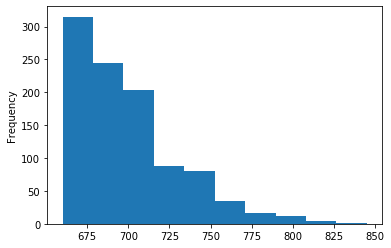

In [88]:
LC_raw['fico_range_low'].plot.hist()

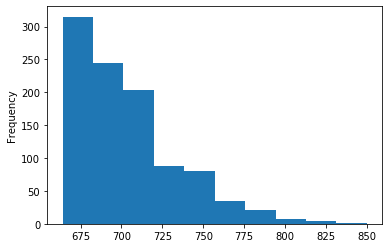

In [89]:
LC_raw['fico_range_high'].plot.hist()

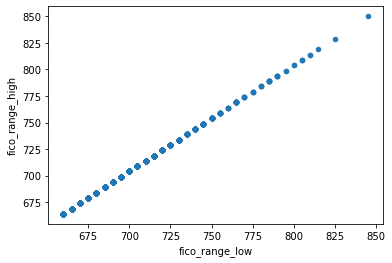

In [90]:
LC_raw.plot.scatter(x='fico_range_low',y='fico_range_high')

In [91]:
LC_raw['grade'].value_counts()

B    338
C    320
A    186
D    103
E     38
F     11
G      2
Name: grade, dtype: int64

In [92]:
LC_raw['sub_grade'].value_counts()

B5    90
C1    76
B1    71
C5    70
B4    62
C2    62
B2    61
C4    58
C3    54
B3    54
A1    53
A4    43
D3    38
A5    36
A2    34
D1    32
A3    20
D2    19
D4    14
E1    12
E2    11
E4     9
F1     5
E3     4
F3     4
E5     2
G2     1
F2     1
G3     1
F5     1
Name: sub_grade, dtype: int64

In [93]:
LC_raw['home_ownership'].value_counts()

MORTGAGE    509
RENT        382
OWN         107
Name: home_ownership, dtype: int64

In [94]:
LC_raw['inq_last_6mths'].value_counts()

0    627
1    265
2     81
3     19
4      6
Name: inq_last_6mths, dtype: int64

In [95]:
LC_raw['issue_d'].value_counts()

Mar-2017    998
Name: issue_d, dtype: int64

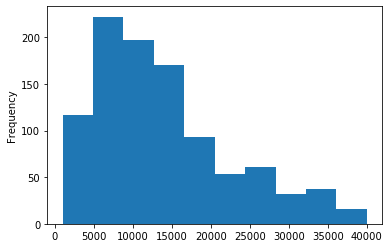

In [97]:
LC_raw['loan_amnt'].plot.hist()

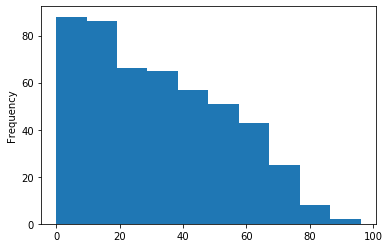

In [98]:
LC_raw['mths_since_last_delinq'].plot.hist()

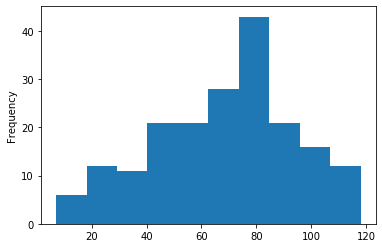

In [99]:
LC_raw['mths_since_last_record'].plot.hist()

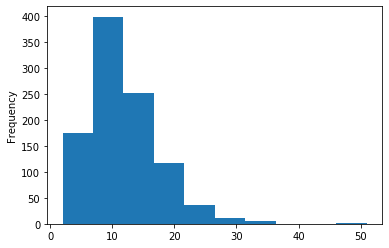

In [100]:
LC_raw['open_acc'].plot.hist()


In [101]:
LC_raw['open_acc'].isna().sum()

0

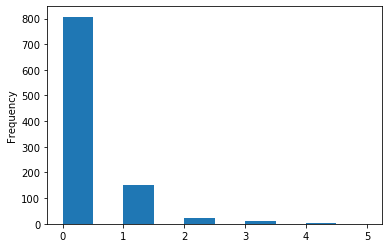

In [102]:
LC_raw['pub_rec'].plot.hist()

In [103]:
LC_raw['purpose'].value_counts()

debt_consolidation    562
credit_card           221
other                  71
home_improvement       70
major_purchase         23
medical                15
vacation               13
car                     8
moving                  7
small_business          5
house                   3
Name: purpose, dtype: int64

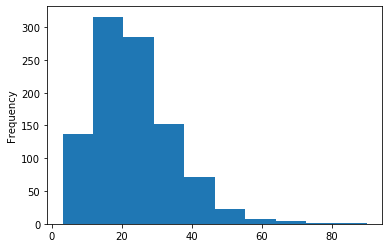

In [105]:
LC_raw['total_acc'].plot.hist()

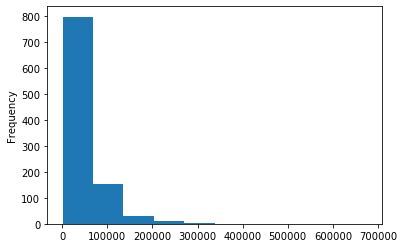

In [106]:
LC_raw['total_bal_ex_mort'].plot.hist()

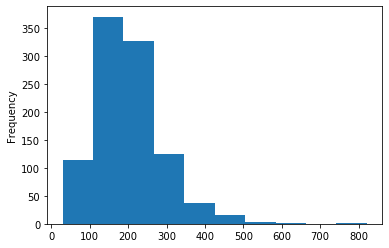

In [107]:
(LC_raw['total_bal_ex_mort']**(1/2)).plot.hist()

In [108]:
LC_raw['zip_code'].value_counts()

945xx    18
070xx    13
088xx    13
112xx    12
921xx    11
         ..
226xx     1
304xx     1
932xx     1
768xx     1
547xx     1
Name: zip_code, Length: 410, dtype: int64

In [109]:
LC_raw['acc_now_delinq'].value_counts()

0    993
1      5
Name: acc_now_delinq, dtype: int64

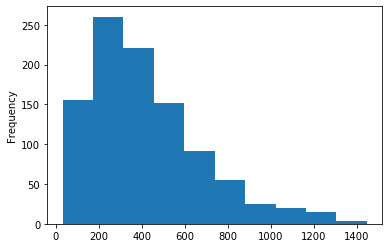

In [112]:
LC_raw['installment'].plot.hist()

In [114]:
LC_raw['collections_12_mths_ex_med'].value_counts()

0    976
1     20
5      1
2      1
Name: collections_12_mths_ex_med, dtype: int64

In [115]:
LC_raw['addr_state'].value_counts()

CA    155
NY     86
TX     79
FL     72
NJ     50
IL     40
PA     38
MD     32
GA     31
OH     29
NC     22
MI     22
CT     19
MN     19
AZ     19
CO     18
IN     18
WA     17
MO     17
MA     16
VA     16
AL     15
TN     14
WI     14
NV     14
OR     13
SC     11
UT     11
OK     10
MS      9
KS      8
LA      7
AR      7
KY      6
HI      6
RI      5
NH      5
VT      4
MT      4
NE      3
WY      3
DC      2
ME      2
AK      2
SD      2
DE      2
ND      2
NM      1
ID      1
Name: addr_state, dtype: int64

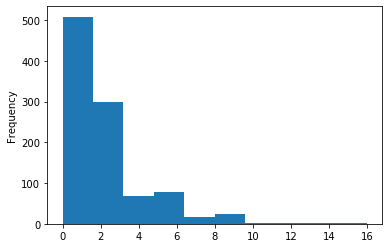

In [116]:

LC_raw['inq_last_12m'].plot.hist()


In [117]:
LC_raw['inq_last_12m'].isna().sum()

0

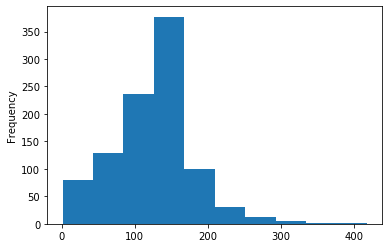

In [118]:
LC_raw['mo_sin_old_il_acct'].plot.hist()


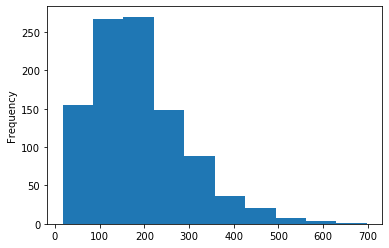

In [119]:
LC_raw['mo_sin_old_rev_tl_op'].plot.hist()


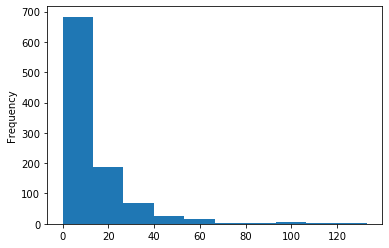

In [120]:
LC_raw['mo_sin_rcnt_rev_tl_op'].plot.hist()

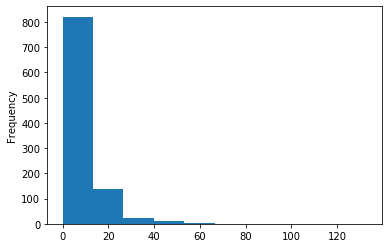

In [121]:
LC_raw['mo_sin_rcnt_tl'].plot.hist()

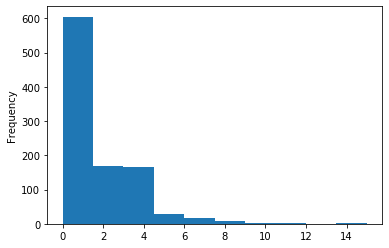

In [122]:
LC_raw['mort_acc'].plot.hist()

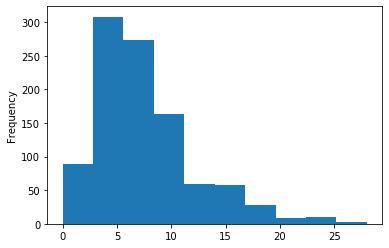

In [125]:
LC_raw['num_bc_tl'].plot.hist()

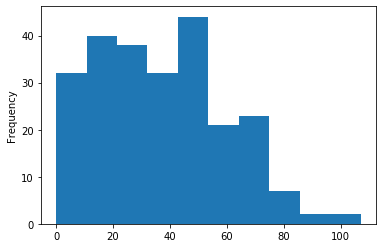

In [124]:
LC_raw['mths_since_recent_bc_dlq'].plot.hist()


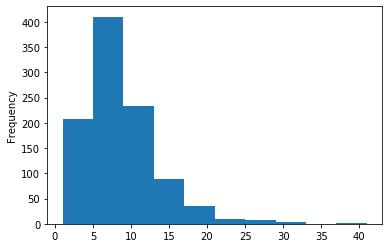

In [126]:
LC_raw['num_op_rev_tl'].plot.hist()

In [129]:
LC_raw['num_tl_op_past_12m'].value_counts()


2     235
1     232
0     199
3     158
4      83
5      42
6      24
7      10
9       7
8       5
13      1
12      1
11      1
Name: num_tl_op_past_12m, dtype: int64

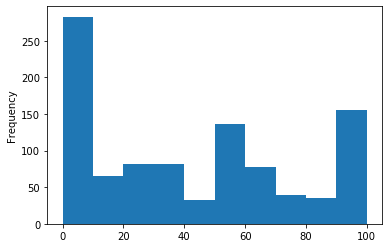

In [130]:
LC_raw['percent_bc_gt_75'].plot.hist()


In [72]:
LC_raw[LC_raw.percent_bc_gt_75.isna() == True][['percent_bc_gt_75','num_bc_tl','total_bc_limit']]



,percent_bc_gt_75,num_bc_tl,total_bc_limit
89,NaN,1,0
134,NaN,0,0
228,NaN,2,0
389,NaN,2,0
392,NaN,3,0
682,NaN,5,0
719,NaN,1,0
927,NaN,0,0
938,NaN,1,0


In [131]:
LC_raw['pub_rec_bankruptcies'].value_counts()

0    875
1    116
2      6
3      1
Name: pub_rec_bankruptcies, dtype: int64

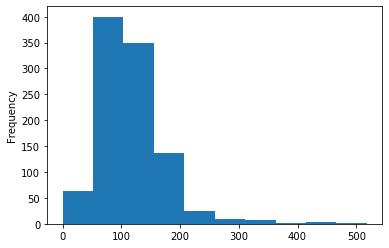

In [146]:
import numpy as np
# np.log(LC_raw['revol_bal']).to_frame().plot.hist()
(LC_raw['revol_bal']**(1/2)).plot.hist()

In [147]:
LC_raw['tax_liens'].value_counts()


0    950
1     28
2      9
3      7
4      3
5      1
Name: tax_liens, dtype: int64

In [148]:
LC_raw['title'].value_counts()


Debt consolidation         562
Credit card refinancing    221
Other                       71
Home improvement            70
Major purchase              23
Medical expenses            15
Vacation                    13
Car financing                8
Moving and relocation        7
Business                     5
Home buying                  3
Name: title, dtype: int64

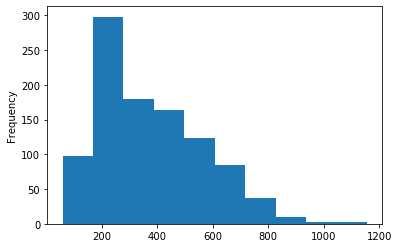

In [150]:
# LC_raw['tot_hi_cred_lim'].plot.hist()

(LC_raw['tot_hi_cred_lim']**(1/2)).plot.hist()

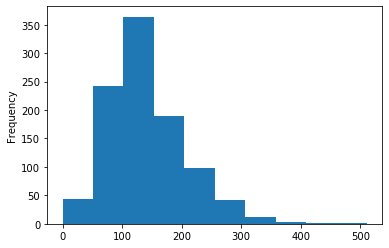

In [151]:
(LC_raw['total_bc_limit']**(1/2)).plot.hist()


In [152]:
LC_raw['verification_status'].value_counts()



Source Verified    414
Not Verified       366
Verified           218
Name: verification_status, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 152 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          int64  
 1   member_id                                   float64
 2   loan_amnt                                   int64  
 3   funded_amnt                                 int64  
 4   funded_amnt_inv                             int64  
 5   term                                        object 
 6   int_rate                                    float64
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                        